In [2]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
import quimb as qu
import quimb.tensor as qtn
from quimb.experimental.merabuilder import MERA
import torch
import torch.nn as nn

## Generator: Tree-TensorNetwork

Following https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131

### Definition

<img src="./images/img1.png" alt="Example Image" width="700" style="display: block; margin-left: auto; margin-right: auto;" />

As illustrated in Fig. 1(b), each circle represents
a tensor; each edge of the circle represents an individual
index of the tensor. The first tensor is a matrix connecting the
second and third tensors, while the remaining tensors are all
three-order tensors with three indices. The index between two
tensors is called a virtual bond, which would be contracted
hereafter. The left and right indices of the tensors in the
bottom of the TTN are respectively connected to two pixels
of the input image and hence are called physical bonds.

The bond dimension in a tensor network refers to the dimension of the shared index (or bond) connecting two tensors. 
Higher bond dimensions allow more complex entanglement between subsystems to be represented. In quantum many-body systems, the bond dimension represents the number of states used to approximate the entanglement structure.

Since bond dimension represents on how many indices we are summing, it is related to how well we can represent states with our tensor network.
In the context of Matrix Product States (MPS), the bond dimension directly corresponds to the Schmidt rank of the state for each bipartition. If the bond dimension is h , the MPS can capture states with a maximum Schmidt rank of h.

$|\psi\rangle=\sum_{i=1}^D \lambda_i\left|u_i\right\rangle_A \otimes\left|v_i\right\rangle_B$, where D is the Schmidt rank, the number of non-zero $\lambda$, which quantifies the enganglement between the two subsystems A and B (for D=1 the state is separable).

In [15]:
def build_ttn(number_physical_indexes, bond_dimension, number_layers):
    #
    # this function builds a tree tensor network with the specified number of physical indexes, bond dimension and number of layers
    # the tree tensor network is composed of number_layers layers of rank-3 random tensors halving the number at each layer
    # the function returns the tensor network, a matrix of tensors composing it and the list of lenghts of each layer
    # root is considered a layer and the function does not check if the number of physical indexes is compatible with the number of layers
    #
    ttn_shape = [int(number_physical_indexes / (2 ** (i + 1))) for i in range(number_layers)]
    
    index = [[] for _ in range(number_layers)]
    index[0] = [f'ph{i}' for i in range(number_physical_indexes)]
    for i in range(1, number_layers):
        index[i] = [f'b{i-1}{j}' for j in range(ttn_shape[i-1])]
    
    tensor = [[] for _ in range(number_layers)]
    tensor[0] = [qtn.rand_tensor([bond_dimension] * 3, inds=[index[0][2 * i], index[0][2 * i + 1], index[1][i]], tags=f't0{i}') for i in range(ttn_shape[0])]
    for i in range(1, number_layers - 1):
        tensor[i] = [qtn.rand_tensor([bond_dimension] * 3, inds=[index[i][2 * j], index[i][2 * j + 1], index[i + 1][j]], tags=f't{i}{j}') for j in range(ttn_shape[i])]
    tensor[number_layers - 1] = [qtn.rand_tensor([bond_dimension] * 2, inds=[index[number_layers - 1][2 * k], index[number_layers - 1][2 * k + 1]], tags=f't{number_layers - 1}{k}') for k in range(ttn_shape[number_layers - 1])]
    
    return qtn.TensorNetwork(tensor), tensor, ttn_shape

In [16]:
number_physical_indexes = 64
bond_dimension = 2
number_layers = 6

tensor_network, tensor, ttn_shape = build_ttn(number_physical_indexes, bond_dimension, number_layers)

In [222]:
# we can access tags of tensors with tensor_map
#  for name, specs in tensor_network.tensor_map.items():
#     print(f"Tensor name: {name}")
#     print(f"Description: {tensor}")
#     print() 

In [ ]:
# tensor_network.draw(show_inds=True,show_tags=True)

We can contract the whole tensor network and calculate the forbenius norm of the resulting rank-8 tensor.

In [224]:
# contracted = tensor_network.contract(all, optimize='auto-hq')
# contracted.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)
# print('norm: ',contracted.norm())

### Canonizing

We can now procede in canonicalization procedure for each layer of the TNN, taking the root tensor as central tensor. In this procedure we have to keep an eye on indexes, since the QR decomposition, the first block of indices is assigned to Q and the second one (in our case, the only "upper" one) is assigned to R, to be contracted with the next layer. The algorithm creates a new set of indexes beetween the first and second layer, that we have to rename.

<div style="text-align: center;">
    <img src="./images/img2.png" alt="Example Image" width="1500" style="display: block; margin-left: auto; margin-right: auto;"/>
    <p>The arrow on U means it's unitary</p>
</div>

Quimb has a default algorith to canonize bonds

In [18]:
for i in range(ttn_shape[1]):
    qtn.tensor_canonize_bond(tensor[0][2*i], tensor[1][i])
    qtn.tensor_canonize_bond(tensor[0][2*i+1], tensor[1][i])
for i in range(ttn_shape[2]):
    qtn.tensor_canonize_bond(tensor[1][2*i], tensor[2][i])
    qtn.tensor_canonize_bond(tensor[1][2*i+1], tensor[2][i])

In [226]:
# print('root norm: ',tensor[2][0].norm())

In [227]:
# contracted = tensor_network.contract(all, optimize='auto-hq')
# contracted.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)
# print(contracted.norm())

Canonization preserves Forbenius norm and the norm of the whole tensor network is given by the norm of the root.

### Perfect sampling algorithm

https://tensornetwork.org/mps/algorithms/sampling/ here the example is aplied to MPS but can be generalized to other TNs, including TTN

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131 chapter II-F

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.85.165146


We can assume our probability distribution to be:
$$p\left(s_1, s_2, s_3, \ldots, s_N\right)=\left|T^{s_1 s_2 s_3 \cdots s_N}\right|^2$$
First we need to make sure it is normalized to one.
$$\sum_{\{s\}}\left|T^{s_1 s_2 s_3 \cdots s_N}\right|^2=1 \text {, or }$$

In [228]:
# tensor_network = tensor_network / tensor_network.norm()

The principle underlying the MPS sampling algorithm below is the “chain rule” of probability

$$p\left(s_1, s_2, s_3, \ldots, s_N\right)=p\left(s_1\right) p\left(s_2 \mid s_1\right) p\left(s_3 \mid s_1 s_2\right) \cdots p\left(s_N \mid s_1 s_2 s_3 \cdots s_{N-1})\right.$$

computing each factor on the right we will get a single sample from the full distribution.

Let' start with $P(s_1)$
$$p\left(s_1\right)=\sum_{s_2, s_3, \ldots, s_N} p\left(s_1, s_2, \ldots, s_N\right)=\sum_{s_2, s_3, \ldots, s_N} T^{s_1 s_2 \cdots s_N} \bar{T}^{s_1 s_2 \ldots s_N}$$

<div style="text-align: center;">
    <img src="./images/img3.png" alt="Sampling Algorithm Image" width="600" style="display: block; margin-left: auto; margin-right: auto;" />
</div>

In [229]:
# step_tensor_network = tensor_network.H.reindex({'ph0':'ph0*'})&tensor_network
# step_tensor_network.draw(color=['t00'],show_tags=True)

In [230]:
# reduced_tensor_network = step_tensor_network.contract(all)
# reduced_tensor_network.draw(color=['t00'],show_inds=True,show_tags=True)

The result is a matrix (“reduced density matrix”), but here we will only need its diagonal elements, ph0=ph0*. 
Contracting with the basis elements (0,1) and (1,0) we get $p(s_0)$ and $p(s_1)$. It must hold $p(s_0)+p(s_1)=1$. Drawing a value from this probability distribution is equivalent to extract a value in $r\in[0,1]$ and if $r<p_1$ then $\hat{s_1}=(0,1)$ and viceversa.

In [231]:
# v0 = qtn.Tensor(data=[0,1], inds=['ph0'])
# v1 = qtn.Tensor(data=[1,0], inds=['ph0'])
# ps0 = v0@reduced_tensor_network@v0.reindex({'ph0':'ph0*'})
# ps1 = v1@reduced_tensor_network@v1.reindex({'ph0':'ph0*'})
# print('ps0: ',ps0)
# print('ps1: ',ps1)
# print('normalization check: ',ps0+ps1)
# r = np.random.uniform(0, 1)
# print('random number: ', r)
# s_hat = [[]]
# if r < ps0:
#     s_hat[0] = v0.data
# else:
#     s_hat[0] = v1.data
# print('s_hat vector: ', s_hat[0])

Now we can contract the tensor network with s0 and repeat the process for $s_2$, to compute $p(s_2|\hat s_1)$, and so on to $p(\hat s_N,....,\hat s_1)$

In [232]:
# v = qtn.Tensor(data=s_hat[0], inds=['ph0'])
# step_tensor_network = step_tensor_network @ v.reindex({'ph0':'ph0*'}) @ v

I will write it down again in one algorithm for convenience

In [19]:
tensor_network = tensor_network / tensor_network.norm()

In [20]:
def perfect_sampling_ttn(ttn,number_indexes):
    s_hat = np.zeros([number_indexes,2])
    probability = np.zeros(number_indexes)

    # cycle 0: the ttn is connected to the conjugate, except for the ph0 index, we obtain a matrix, multiplied by the basis vectors
    # gives me the probability of extracting the first element. We extract the first element
    # cycle 1: the vector extracted in the previous cycle is connected to the ph0 index of the ttn. The procedure repeats identically

    for i in range(number_indexes):
        step_tensor_network = tensor_network

        for j in range(i): 
            # for each cycle connect a tensor to an index (in sequence from ph0 to ph14) up to the index before 
            # the one I want to sample
            v = qtn.Tensor(data=s_hat[j], inds=[f'ph{j}'], tags=[f'v{int(s_hat[j][0])}'])
            step_tensor_network = step_tensor_network & v
            step_tensor_network = step_tensor_network / np.sqrt(probability[j])

        # take the complex conjugate of the new network with the same indices as the first one except for the one I want to sample
        step_tensor_network_full = step_tensor_network.H.reindex({f'ph{i}':f'ph{i}*'}) & step_tensor_network

        # contraction of the network, I get the probability matrix of extracting the new element
        reduced_tensor_network = step_tensor_network_full.contract(all)

        # calculate the probability of extracting the two elements
        v0 = qtn.Tensor(data=[0,1], inds=[f'ph{i}'])
        v1 = qtn.Tensor(data=[1,0], inds=[f'ph{i}'])
        ps0 = v0 @ reduced_tensor_network @ v0.reindex({f'ph{i}':f'ph{i}*'})
        ps1 = v1 @ reduced_tensor_network @ v1.reindex({f'ph{i}':f'ph{i}*'})

        ##########NORMALIZATION TEST############
        if ps0+ps1<0.999 or ps0+ps1>1.001:
            print("errore al ciclo: ",i)
            print('ps0: ',ps0)
            print('ps1: ',ps1)
        ########################################

        #extracting new element
        r = np.random.uniform(0, 1)
        if r < ps0:
            s_hat[i] = v0.data
            probability[i] = ps0
        else:
            s_hat[i] = v1.data
            probability[i] = ps1
    return s_hat

We can make a frequency histogram sampling the distribution

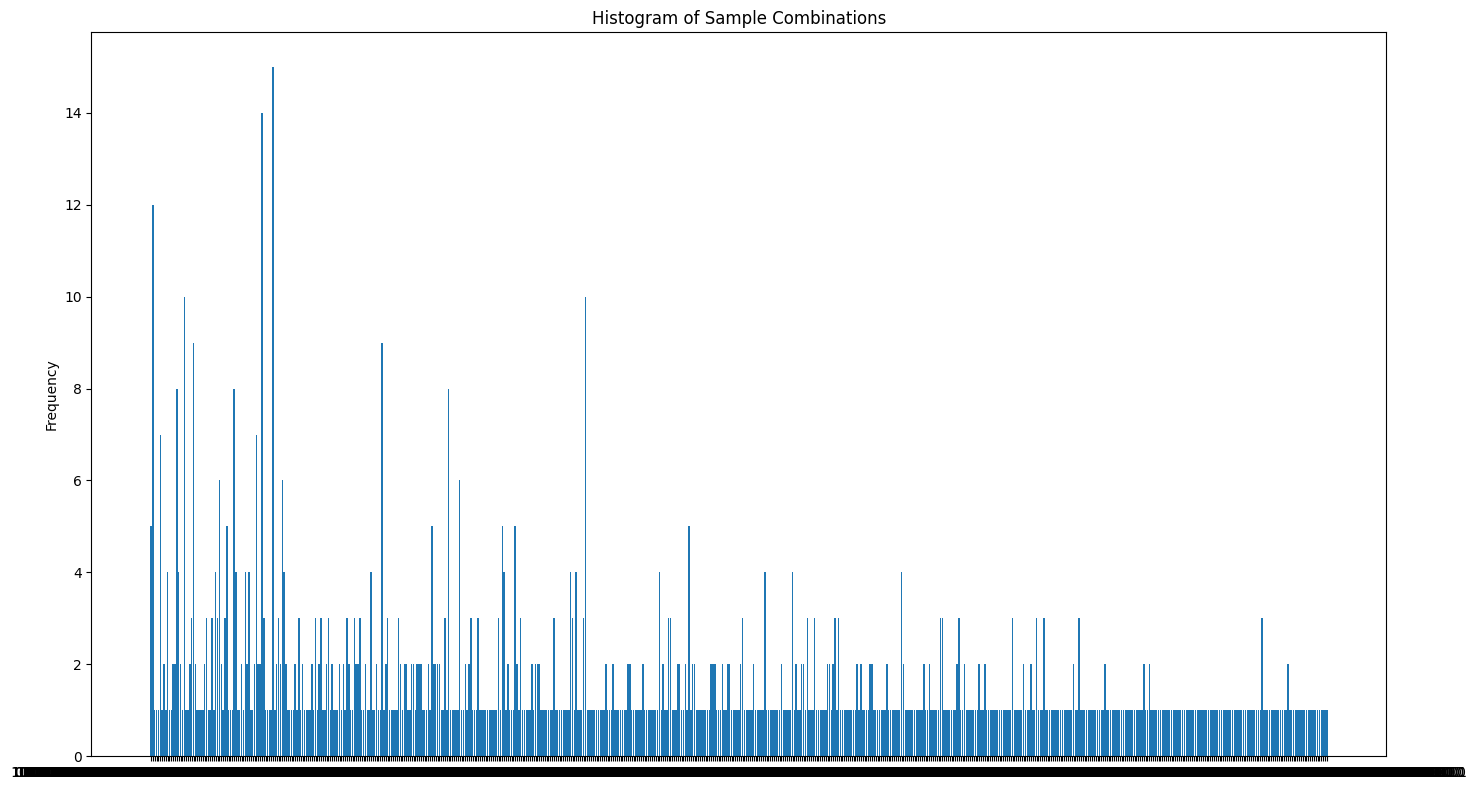

In [257]:
# from collections import Counter
# import matplotlib.pyplot as plt

# samples = []
# for _ in range(1000):
#     sample = perfect_sampling_ttn(tensor_network, number_physical_indexes)
#     samples.append(tuple(sample.flatten()))

# # Count the occurrences of each unique sample
# sample_counts = Counter(samples)

# # Create histogram
# labels, values = zip(*sample_counts.items())
# indexes = range(len(labels))

# plt.figure(figsize=(15, 8)) 
# plt.bar(indexes, values, tick_label=["".join(map(str, map(int, label))) for label in labels])
# plt.ylabel('Frequency')
# plt.title('Histogram of Sample Combinations')
# plt.tight_layout()
# plt.show()

In [28]:
import os

sample = perfect_sampling_ttn(tensor_network, number_physical_indexes)
#convert to 8x8 matrix
sample_matrix = sample.reshape(8, 8, bond_dimension)[:, :, 0]
print(sample_matrix)

os.makedirs('/workspaces/ML_TTN/generated_samples/', exist_ok=True)
np.savetxt('/workspaces/ML_TTN/generated_samples/example.txt', sample_matrix, fmt='%d')

[[0. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0.]]


## Discriminator: Convolutional Neural Network

As a discriminatore we will use a classical neural network. Since the output of the generator consists of images we will use a standard CNN.

In [54]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_channels=1, img_size=16):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate the size of the downsampled image
        self.ds_size = img_size // 2**3
        self.adv_layer = nn.Sequential(nn.Linear(256 * self.ds_size * self.ds_size, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

Loading samples from structured dataset of 8 x 8 images produce by script "dataset_make.py" and generated examples and doing a pass through model for testing.

In [63]:
discriminator = Discriminator(img_size=8)

# Load dataset examples
load = np.loadtxt('./dataset/imagesA/imageA_0.txt', delimiter=' ')
real_sample = torch.tensor(load, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Load generated samples
load = np.loadtxt('./dataset/imagesA/imageA_0.txt', delimiter=' ')
fake_sample = torch.tensor(load, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Pass the real sample through the discriminator
print("real sample shape: ", real_sample.shape)
out = discriminator(real_sample)
print("probability output:", out)

print("fake sample shape: ",fake_sample.shape)
out = discriminator(fake_sample)
print("probability output:", out)


real sample shape:  torch.Size([1, 1, 8, 8])
probability output: tensor([[0.5061]], grad_fn=<SigmoidBackward0>)
fake sample shape:  torch.Size([1, 1, 8, 8])
probability output: tensor([[0.5061]], grad_fn=<SigmoidBackward0>)


## MERA generator

### Definition

In [40]:
# number of sites
n = 2**6

# max bond dimension
D = 2

# use single precision for quick GPU optimization
dtype = 'float32'
mera = qtn.MERA.rand_invar(n, D, dtype=dtype)

In [41]:
from math import cos, sin, pi

fix = {
    f'k{i}': (sin(2 * pi * i / n), cos(2 * pi * i / n))
    for i in range(n)
}

# reduce the 'spring constant' k as well
draw_opts = dict(fix=fix, k=0.01)

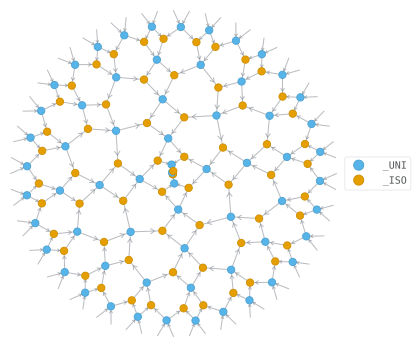

In [27]:
mera.draw(color=['_UNI', '_ISO'], **draw_opts)

Physical indexes in layer 0 are named $k_0, k_1, ..., k_{63}$

In [42]:
# for t in mera:
#     if '_UNI' in t.tags and '_LAYER0' in t.tags:
#         print(t)

IsoTensor(shape=(2, 2, 2, 2), inds=('k0', 'k1', '_9ca6daAAAdI_0', '_9ca6daAAAdI_1'), tags=oset(['_UNI', '_LAYER0', 'I0', 'I1']), left_inds=('k0', 'k1'), backend='numpy', dtype='float32')
IsoTensor(shape=(2, 2, 2, 2), inds=('k2', 'k3', '_9ca6daAAAdI_2', '_9ca6daAAAdI_3'), tags=oset(['_UNI', '_LAYER0', 'I2', 'I3']), left_inds=('k2', 'k3'), backend='numpy', dtype='float32')
IsoTensor(shape=(2, 2, 2, 2), inds=('k4', 'k5', '_9ca6daAAAdI_4', '_9ca6daAAAdI_5'), tags=oset(['_UNI', '_LAYER0', 'I4', 'I5']), left_inds=('k4', 'k5'), backend='numpy', dtype='float32')
IsoTensor(shape=(2, 2, 2, 2), inds=('k6', 'k7', '_9ca6daAAAdI_6', '_9ca6daAAAdI_7'), tags=oset(['_UNI', '_LAYER0', 'I6', 'I7']), left_inds=('k6', 'k7'), backend='numpy', dtype='float32')
IsoTensor(shape=(2, 2, 2, 2), inds=('k8', 'k9', '_9ca6daAAAdI_8', '_9ca6daAAAdI_9'), tags=oset(['_UNI', '_LAYER0', 'I8', 'I9']), left_inds=('k8', 'k9'), backend='numpy', dtype='float32')
IsoTensor(shape=(2, 2, 2, 2), inds=('k10', 'k11', '_9ca6daAAAdI_1

### Perfect sampling

In [43]:
def perfect_sampling_ttn(ttn,number_indexes):
    s_hat = np.zeros([number_indexes,2])
    probability = np.zeros(number_indexes)

    # cycle 0: the ttn is connected to the conjugate, except for the ph0 index, we obtain a matrix, multiplied by the basis vectors
    # gives me the probability of extracting the first element. We extract the first element
    # cycle 1: the vector extracted in the previous cycle is connected to the ph0 index of the ttn. The procedure repeats identically

    for i in range(number_indexes):
        step_tensor_network = ttn

        for j in range(i): 
            # for each cycle connect a tensor to an index (in sequence from ph0 to ph14) up to the index before 
            # the one I want to sample
            v = qtn.Tensor(data=s_hat[j], inds=[f'k{j}'], tags=[f'v{int(s_hat[j][0])}'])
            step_tensor_network = step_tensor_network & v
            step_tensor_network = step_tensor_network / np.sqrt(probability[j])

        # take the complex conjugate of the new network with the same indices as the first one except for the one I want to sample
        step_tensor_network_full = step_tensor_network.H.reindex({f'k{i}':f'k{i}*'}) & step_tensor_network

        # contraction of the network, I get the probability matrix of extracting the new element
        reduced_tensor_network = step_tensor_network_full.contract(all)

        # calculate the probability of extracting the two elements
        v0 = qtn.Tensor(data=[0,1], inds=[f'k{i}'])
        v1 = qtn.Tensor(data=[1,0], inds=[f'k{i}'])
        ps0 = v0 @ reduced_tensor_network @ v0.reindex({f'k{i}':f'k{i}*'})
        ps1 = v1 @ reduced_tensor_network @ v1.reindex({f'k{i}':f'k{i}*'})

        ##########NORMALIZATION TEST############
        if ps0+ps1<0.999 or ps0+ps1>1.001:
            print("errore al ciclo: ",i)
            print('ps0: ',ps0)
            print('ps1: ',ps1)
        ########################################

        #extracting new element
        r = np.random.uniform(0, 1)
        if r < ps0:
            s_hat[i] = v0.data
            probability[i] = ps0
        else:
            s_hat[i] = v1.data
            probability[i] = ps1
    return s_hat

In [44]:
import os

sample = perfect_sampling_ttn(mera, 64)
#convert to 8x8 matrix
sample_matrix = sample.reshape(8, 8, 2)[:, :, 0]
print(sample_matrix)

os.makedirs('/workspaces/ML_TTN/generated_samples/', exist_ok=True)
np.savetxt('/workspaces/ML_TTN/generated_samples/example.txt', sample_matrix, fmt='%d')

[[0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 0. 1.]]


## GAN

### Generator

First we define a tensor network MERA, with a rank of 64 and bond dimension 2.

In [3]:
# number of sites
n = 2**6

# max bond dimension
D = 2

# use single precision for quick GPU optimization
dtype = 'float32'
mera = qtn.MERA.rand_invar(n, D, dtype=dtype)

from math import cos, sin, pi

fix = {
    f'k{i}': (sin(2 * pi * i / n), cos(2 * pi * i / n))
    for i in range(n)
}

# reduce the 'spring constant' k as well
draw_opts = dict(fix=fix, k=0.01)

#mera.draw(color=['_UNI', '_ISO'], **draw_opts)

Define perfect sampling as in chapter 1.3. The standard name for uncontracted indices is $k_i$, and now all the tensors must have pytorch backend.

In [4]:
def perfect_sampling_ttn(ttn,number_indexes):
    s_hat = np.zeros([number_indexes,2])
    probability = np.zeros(number_indexes)

    # cycle 0: the ttn is connected to the conjugate, except for the ph0 index, we obtain a matrix, multiplied by the basis vectors
    # gives me the probability of extracting the first element. We extract the first element
    # cycle 1: the vector extracted in the previous cycle is connected to the ph0 index of the ttn. The procedure repeats identically

    for i in range(number_indexes):
        step_tensor_network = ttn

        for j in range(i): 
            # for each cycle connect a tensor to an index (in sequence from ph0 to ph14) up to the index before 
            # the one I want to sample
            v = qtn.Tensor(data=torch.tensor(s_hat[j], dtype=torch.float32), inds=[f'k{j}'], tags=[f'v{int(s_hat[j][0])}'])
            step_tensor_network = step_tensor_network & v
            step_tensor_network = step_tensor_network / np.sqrt(probability[j])

        # take the complex conjugate of the new network with the same indices as the first one except for the one I want to sample
        step_tensor_network_full = step_tensor_network.H.reindex({f'k{i}':f'k{i}*'}) & step_tensor_network

        # contraction of the network, I get the probability matrix of extracting the new element
        reduced_tensor_network = step_tensor_network_full.contract(all)

        # calculate the probability of extracting the two elements
        v0 = qtn.Tensor(data=torch.tensor([0, 1], dtype=torch.float32), inds=[f'k{i}'])
        v1 = qtn.Tensor(data=torch.tensor([1, 0], dtype=torch.float32), inds=[f'k{i}'])
        
        ps0 = v0 @ reduced_tensor_network @ v0.reindex({f'k{i}':f'k{i}*'})
        ps1 = v1 @ reduced_tensor_network @ v1.reindex({f'k{i}':f'k{i}*'})

        ##########NORMALIZATION TEST############
        if ps0+ps1<0.999 or ps0+ps1>1.001:
            print("errore al ciclo: ",i)
            print('ps0: ',ps0)
            print('ps1: ',ps1)
        ########################################

        #extracting new element
        r = np.random.uniform(0, 1)
        if r < ps0:
            s_hat[i] = v0.data
            probability[i] = ps0
        else:
            s_hat[i] = v1.data
            probability[i] = ps1
    return s_hat

Isometrizing network

In [5]:
def norm_fn(mera):
    # parametrize our tensors as isometric/unitary
    return mera.isometrize(method="cayley")

We need to make the tn made up of pytorch objects

https://quimb.readthedocs.io/en/latest/examples/ex_quimb_within_torch.html

In [6]:
#mera.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))

class Generator(torch.nn.Module):

    def __init__(self, tn):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(tn)
        # n.b. you might want to do extra processing here to e.g. store each
        # parameter as a reshaped matrix (from left_inds -> right_inds), for
        # some optimizers, and for some torch parametrizations
        self.torch_params = torch.nn.ParameterDict({
            # torch requires strings as keys
            str(i): torch.nn.Parameter(initial)
            for i, initial in params.items()
        })

    def forward(self):
        # convert back to original int key format
        params = {int(i): p for i, p in self.torch_params.items()}
        # reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
        # isometrize and then return the energy
        return perfect_sampling_ttn(norm_fn(psi), 64)

In [ ]:
# TEST
# mera.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
# fake_sample = Generator(mera).forward()
# print(fake_sample)

### Discriminator

As discriminator we can use a standard CNN to get probability for the sample to be fake or real.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size=64):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        data = data.view(data.size(0), -1)  # Flatten the input tensor
        out = self.model(data)
        return out

### Training loop

In [8]:
def real_batch_maker(batch_size, n=8, noise_level=0.1):
    # Define 8x8 matrices for digits 1
    digit_1 = np.array([
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0]
    ], dtype=np.float32)

    matrices = []
    for i in range(batch_size):
        # Add noise to digit 1
        noise = np.random.rand(n, n) < noise_level
        noisy_digit_1 = np.where(noise, 1 - digit_1, digit_1)
        matrices.append(noisy_digit_1.flatten())
    return np.array(matrices).T

In [9]:
def fake_batch_maker(generator, batch_size):
    fake_batch=[]
    for _ in range(batch_size):
        fake_sample = generator.forward()
        # Convert each row ([0,1] or [1,0] states) of fake_sample to a single value: 0 and 1
        fake_column_vector = np.array([0 if np.array_equal(row, [0, 1]) else 1 for row in fake_sample])
        fake_batch.append(fake_column_vector)
    return fake_batch

In [11]:
# setting hyperparameters, since i am using synthetic dataset i am making up the size of the dataset
# for each batch number iteration i will generate a new fake batch
num_epochs = 100
batch_number = 2
batch_size = 5

# initialize models
mera.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
generator = Generator(mera)
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.1)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.1)

# Training loop
for epoch in range(num_epochs):
    for i in range(batch_number):
        
        # Generate real data
        real_data = torch.tensor(np.array(real_batch_maker(batch_size)), dtype=torch.float32)
        #batch_size = real_data.size(0)

        # Generate fake data
        fake_data = torch.tensor(np.array(fake_batch_maker(generator, batch_size)), dtype=torch.float32)

        # Create labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train discriminator on real data
        outputs = discriminator(real_data.T)
        loss_real = criterion(outputs, real_labels)

        # Train discriminator on fake data
        outputs = discriminator(fake_data.detach())
        loss_fake = criterion(outputs, fake_labels)
        
        # Total loss for discriminator
        loss_D = loss_real + loss_fake
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        outputs = discriminator(fake_data)
        loss_G = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")


/tmp/ipykernel_43026/156193343.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mera.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
/tmp/ipykernel_43026/1780068886.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  s_hat[i] = v0.data
/tmp/ipykernel_43026/1780068886.py:45: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  s_hat[i] = v1.data


Epoch [1/100], Loss D: 7.317843437194824, Loss G: 0.0
Epoch [2/100], Loss D: 100.0, Loss G: 9.357641220092773
Epoch [3/100], Loss D: 0.0, Loss G: 100.0
Epoch [4/100], Loss D: 32.309078216552734, Loss G: 80.0


KeyboardInterrupt: 